# Mount Google Drive 

In [ ]:
# Authorization User

# installing necessary libraries to perform authorization

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
# Mount google drive as disk

!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [ ]:
# Create new folder if it does not exist

# import os
# os.mkdir("/content/drive/Emotion_Analysis")
# os.chdir("/content/drive/") # chdir is used for !ls commands
# !ls

In [ ]:
# Check contents of folder working with
import os

os.chdir("/content/drive/Emotion_Analysis")
!ls

data  embeddings  models


In [ ]:
# Append new folder/ path of folder to use to perform operations

import sys
sys.path.append('/content/drive/Emotion_Analysis')

In [ ]:
# not working   # Check the content of the new dir/ or folder working on 
# not working   # os.chdir("/content/drive/Emotion_Analysis")
# not working   # os.chdir("/")
# not working   # !ls 

# print out appended working folder path
print(sys.path[-1])

/content/drive/Emotion_Analysis


# Emotion Classification in texts using GRU and Word2Vec

Workflow:


1.   Import Data
2.   Prepare the input data
3.   Import pre-trained W2V
4.   Create Neural Network Pipeline
5.   Train The Model
6.   Evaluate results
7.   save the trained model for later use

In [ ]:
# 1. Import Data

import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Defining vector space dimension and fixed input size

# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [ ]:
import io

#Append your path
# import sys
# sys.path.append('/content/drive/Emotion_Analysis')


# reference code
# data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
# data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')
# loaded_csv_file = pd.read_csv(io.BytesIO(data_to_load['filename.csv']))

# data_train = pd.read_csv(io.BytesIO(data_to_load['data_train.csv']), encoding='utf-8')
# data_test = pd.read_csv(io.BytesIO(data_to_load['data_test.csv']), encoding='utf-8')


data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')


X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [ ]:
# printing out first 10 values of data_test to check if it was loaded correctly
print(data.Emotion.value_counts())
data.head(20)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...
6,joy,Finding out I am chosen to collect norms for C...
7,anger,A spokesperson said : ` Glen is furious that t...
8,neutral,Yes .
9,sadness,"When I see people with burns I feel sad, actua..."


# Preparing the input data

In this section we will preprocess the data so we can load it to our NN Model (LSTM)

the preprocessing will be done in the following steps
1. Tokenize our texts and count unique tokens
2. Padding: each input (sentence or text) has to be of the same length
3. Labels have to be converted to integeres and categorized


Basic preprocessing and tokenization using nltk to double check that sentences are properly split into words. We could also add stopword removal but steps like stemming or lemmatization are not needed since we are using word2vec and words with the same stem can have a different meaning

In [ ]:
# defining a function to clean data

def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
# printing out some of the texts to check if they were cleaned properly

print('texts_train[92]: ',texts_train[92])
print('texts_train[56]: ',texts_train[56])
print('texts_train[34]: ',texts_train[34])

texts_train[92]:  a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .
texts_train[56]:  This feeling occurred to me when my colleague entered in G.V . ( University ) and I did n't .
texts_train[34]:  When biking and I felt very bad ( problems with heart and respiration ) .


In [ ]:
# Tokenizing and fitting the model using keras library

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12088


In [ ]:
# Padding inputs so each of them have the same length

# We defined maximun number of words for our texts and input size to our model has to be fixed - 
# padding with zeros to keep the same input lenght (longest input in our dataset is ~250 words)


X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10259,   173,    13]], dtype=int32)

In [ ]:
# Categorizing labels

encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

# Import pretrained word vectors (w2v)


*   Importing pretrained word2vec from file and creating embedding matrix
*   We will later map each word in our corpus to existing word vector

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

You can download and import any pre-trained word embeddings. I will use 300 dimentional w2v pre-trained on wikipedia articles. Download fast text english 
<br>

---


vectors: https://fasttext.cc/docs/en/english-vectors.html


In [ ]:
# check if embedding file is there
os.chdir("/content/drive/Emotion_Analysis/embeddings/")
!ls

wiki-news-300d-1M.vec  wiki-news-300d-1M.vec.zip


In [ ]:
import urllib.request
import zipfile
import os

fname = '/content/drive/Emotion_Analysis/embeddings/wiki-news-300d-1M.vec'

if os.path.isfile(fname):
  print("found")  

found


In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12089, 300)

Some of the words from our corpus were not included in the pre-trained word vectors. If we inspect those words we'll see that it's mostly spelling errors. It's also good to double check the noise in our data f.e different languages or tokenizer errors.

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 646


# Create LSTM Pipeline

**Embedding Layer**

We will use pre-trained word vectors. We could also train our own embedding layer if we don't specify the pre-trained weights

* vocabulary size: the maximum number of terms that are used to represent a text: e.g. if we set the size of the “vocabulary” to 1000 only the first thousand terms most frequent in the corpus will be considered (and the other terms will be ignored)
* the maximum length: of the texts (which must all be the same length)
* size of embeddings: basically, the more dimensions we have the more precise the semantics will be, but beyond a certain threshold we will lose the ability of the embedding to define a coherent and general enough semantic area
* trainable: True if you want to fine-tune them while training


In [ ]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,embed_num_dims,input_length = max_seq_len,weights = [embedd_matrix],trainable=False)

**Model Pipeline**

* the input is the first N words of each text (with proper padding)
* the first level creates embedding of words, using vocabulary with a certain dimension, and a given size of embeddings
* LSTM/GRU layer which will receive word embeddings for each token in the tweet as inputs. The intuition is that its output tokens will store information not only of the initial token, but also any previous tokens; In other words, the LSTM layer is generating a new encoding for the original input.
* the output level has a number of neurons equal to the classes of the problem and a “softmax” activation function


**You can change GRU to LSTM. The results will be very similar but LSTM might take longer to train.**


In [ ]:
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3626700   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 3,958,225
Trainable params: 331,525
Non-trainable params: 3,626,700
_________________________________________________________________


# Train the Model - version 2 - 30 epochs

**validation data:** use validation_split in order to estimate how well your model has been trained and adjust parameters or add dropout layers. After that we will train the model using the complete train set.

**epochs:** 30 


**batch_size:** 128

In [ ]:
batch_size = 128
epochs = 30

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/30
62/62 [==============================] - 404s 6s/step - loss: 1.5012 - accuracy: 0.3152 - val_loss: 1.2727 - val_accuracy: 0.4786
Epoch 2/30
62/62 [==============================] - 400s 6s/step - loss: 1.1809 - accuracy: 0.5282 - val_loss: 1.0231 - val_accuracy: 0.6127
Epoch 3/30
62/62 [==============================] - 400s 6s/step - loss: 0.9222 - accuracy: 0.6576 - val_loss: 0.8378 - val_accuracy: 0.6905
Epoch 4/30
62/62 [==============================] - 399s 6s/step - loss: 0.8200 - accuracy: 0.6970 - val_loss: 0.8067 - val_accuracy: 0.7121
Epoch 5/30
62/62 [==============================] - 398s 6s/step - loss: 0.7491 - accuracy: 0.7295 - val_loss: 0.7902 - val_accuracy: 0.7129
Epoch 6/30
62/62 [==============================] - 398s 6s/step - loss: 0.7183 - accuracy: 0.7428 - val_loss: 0.7608 - val_accuracy: 0.7241
Epoch 7/30
62/62 [==============================] - 401s 6s/step - loss: 0.7163 - accuracy: 0.7420 - val_loss: 0.7678 - val_accuracy: 0.7182
Epoch 8/30
62

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'], 'g')
plt.plot(hist.history['val_accuracy'], ':r')
plt.title('GRU v2 model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# "Loss"
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], ':g')
plt.title('GRU v2 model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()



NameError: ignored

# Evaluation

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 74.51%

F1 Score: 74.51


**Plotting confusion Matrix: **

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
                          # cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 74.51


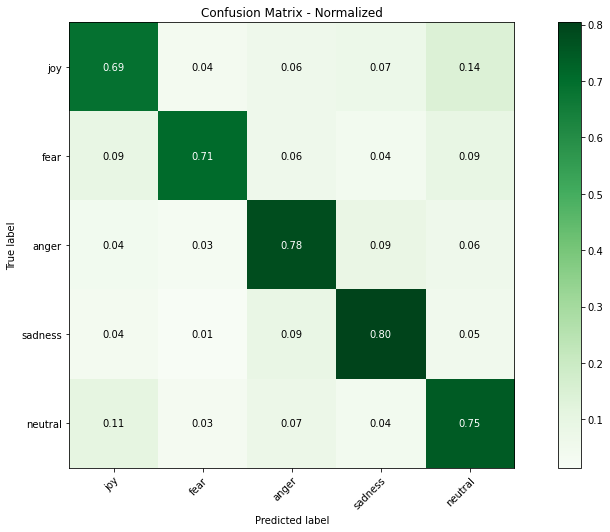

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Confusion Matrix - Normalized')
plt.show()

# Playing with model


In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[20], predictions[20]))

Message: I was very happy when my scholarship to continue studying at university was approved after it had been cancelled.
Predicted: joy


In [ ]:
# testing how long each prediction takes

import time

message = ["I want to kill my self"]
# message = ["I was very happy when my scholarship to continue studying at university was approved after it had been cancelled"]
# message = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled"]
# message = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very fucking thrilled about it"]


seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['I want to kill my self']
predicted: anger (0.17 seconds)


**Testing input variations with the model**


In [ ]:
# testing how long each prediction takes

import time

message1 = ["I'm having a panic attack"]

message2 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died"]
message3 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it"]
message4 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it but then found out It all goes to my ex wife. I think I'm depressed now"]
message5 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it but then found out It all goes to my ex wife. I am super annoyed right now"]
# message5 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it but then found out It all goes to my ex wife. I think I'm depressed now, I'm very very angry right now. I'm angry, angry. angry angry very angry, I am sad I am sad I am sad"]


seq1 = tokenizer.texts_to_sequences(message1)
seq2 = tokenizer.texts_to_sequences(message2)
seq3 = tokenizer.texts_to_sequences(message3)
seq4 = tokenizer.texts_to_sequences(message4)
seq5 = tokenizer.texts_to_sequences(message5)

padded1 = pad_sequences(seq1, maxlen=max_seq_len)
padded2 = pad_sequences(seq2, maxlen=max_seq_len)
padded3 = pad_sequences(seq3, maxlen=max_seq_len)
padded4 = pad_sequences(seq4, maxlen=max_seq_len)
padded5 = pad_sequences(seq5, maxlen=max_seq_len)

# prediction 1
start_time1 = time.time()
prediction1 = model.predict(padded1)
# prediction 2
start_time2 = time.time()
prediction2 = model.predict(padded2)
# prediction 3
start_time3 = time.time()
prediction3 = model.predict(padded3)
# prediction 4
start_time4 = time.time()
prediction4 = model.predict(padded4)
# prediction 5
start_time5 = time.time()
prediction5 = model.predict(padded5)

print('Message-1: ' + str(message1))
print('prediction-1: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction1)], (time.time() - start_time1)))
print('')

print('Message-2: ' + str(message2))
print('prediction-2: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction2)], (time.time() - start_time2)))
print('')

print('Message-3: ' + str(message3))
print('prediction-3: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction3)], (time.time() - start_time3)))
print('')

print('Message-4: ' + str(message4))
print('prediction-4: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction4)], (time.time() - start_time4)))
print('')

print('Message-5: ' + str(message5))
print('prediction-5: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction5)], (time.time() - start_time5)))

Message-1: ["I'm having a panic attack"]
prediction-1: fear (0.76 seconds)

Message-2: ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died"]
prediction-2: sadness (0.61 seconds)

Message-3: ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it"]
prediction-3: joy (0.46 seconds)

Message-4: ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it but then found out It all goes to my ex wife. I think I'm depressed now"]
prediction-4: sadness (0.31 seconds)

Message-5: ["I was very happy when my scholarship to go to flight school was approved after it had been 

# Saving Model - version 2 with 30 epochs

saving the model in hierarchical data format - h5 so we can load it later



In [ ]:
# v2 save

model.save('/content/drive/Emotion_Analysis/models/bi_gru_w2vec_v2_30eps.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
# v2 load

from keras.models import load_model
loaded_model_v2 = load_model('/content/drive/Emotion_Analysis/models/bi_gru_w2vec_v2_30eps.h5')

# Using Saved Model

v2 with 30 epochs



In [ ]:
import time

# message = ["I was very happy when my scholarship to continue studying at university was approved after it had been cancelled"]
# message = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled"]
message = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died"]


seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred1 = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died"]
predicted: anger (0.17 seconds)


In [ ]:
# testing how long each prediction takes

import time

message1 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled"]
message2 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died"]
message3 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it"]
message4 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it but then found out It all goes to my ex wife. I think I'm depressed now"]
message5 = ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it but then found out It all goes to my ex wife. I am super annoyed right now"]

seq1 = tokenizer.texts_to_sequences(message1)
seq2 = tokenizer.texts_to_sequences(message2)
seq3 = tokenizer.texts_to_sequences(message3)
seq4 = tokenizer.texts_to_sequences(message4)
seq5 = tokenizer.texts_to_sequences(message5)

padded1 = pad_sequences(seq1, maxlen=max_seq_len)
padded2 = pad_sequences(seq2, maxlen=max_seq_len)
padded3 = pad_sequences(seq3, maxlen=max_seq_len)
padded4 = pad_sequences(seq4, maxlen=max_seq_len)
padded5 = pad_sequences(seq5, maxlen=max_seq_len)

# prediction 1
start_time1 = time.time()
prediction1 = loaded_model_v2.predict(padded1)
# prediction 2
start_time2 = time.time()
prediction2 = loaded_model_v2.predict(padded2)
# prediction 3
start_time3 = time.time()
prediction3 = loaded_model_v2.predict(padded3)
# prediction 4
start_time4 = time.time()
prediction4 = loaded_model_v2.predict(padded4)
# prediction 5
start_time5 = time.time()
prediction5 = loaded_model_v2.predict(padded5)

print('Message-1: ' + str(message1))
print('prediction-1: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction1)], (time.time() - start_time1)))
print('')

print('Message-2: ' + str(message2))
print('prediction-2: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction2)], (time.time() - start_time2)))
print('')

print('Message-3: ' + str(message3))
print('prediction-3: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction3)], (time.time() - start_time3)))
print('')

print('Message-4: ' + str(message4))
print('prediction-4: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction4)], (time.time() - start_time4)))
print('')

print('Message-5: ' + str(message5))
print('prediction-5: {} ({:.2f} seconds)'.format(class_names[np.argmax(prediction5)], (time.time() - start_time5)))

Message-1: ['I was very happy when my scholarship to go to flight school was approved after it had been cancelled']
prediction-1: joy (0.77 seconds)

Message-2: ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died"]
prediction-2: sadness (0.62 seconds)

Message-3: ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it"]
prediction-3: joy (0.46 seconds)

Message-4: ["I was very happy when my scholarship to go to flight school was approved after it had been cancelled, but now I'm sad that my dad died and now I just won the lottery so I will celebrate my victory and I am very thrilled about it but then found out It all goes to my ex wife. I think I'm depressed now"]
prediction-4: sadness (0.30 seconds)

Message-5: ["I was very happy 

---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
# my matplotlib experiments

---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---




In [ ]:
apl_price = [93.95, 112.15, 104.05, 144.85, 169.49]
ms_price = [39.01, 50.29, 57.05, 69.98, 94.39]
year = [2014, 2015, 2016, 2017, 2018]

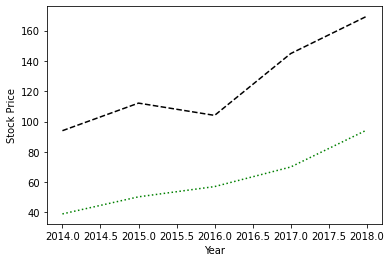

In [ ]:
plt.plot(year, apl_price, '--k' ,year, ms_price, ':g')

plt.xlabel('Year')
plt.ylabel('Stock Price')
# plt.fill_between(apl_price, ms_price)
plt.show()


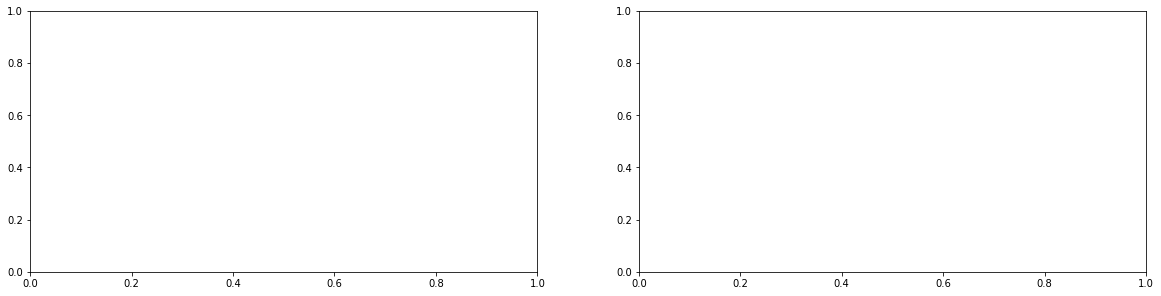

In [ ]:
fig_1 = plt.figure(1, figsize=(20, 4.8))
chart_1 = fig_1.add_subplot(121)
chart_2 = fig_1.add_subplot(122)

In [ ]:
import time

count = 0
while (count != 180):
  time.sleep(60)  
  print('minute: ',count)
  count=count+1
print('total time: ', count/60, 'hours | ', count, ' minutes in total' )



KeyboardInterrupt: ignored